In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from skimage import morphology
import os

In [ ]:
root = "Z:/Projectline_modelling_lung_cancer/Nii_Processed/"
root = "//zkh/appdata/RTDicom/Projectline_modelling_lung_cancer/Users/Luis/CT_ITV_GTV_XBP_Nii/"

In [ ]:
PxList = os.listdir(root)
len(PxList)

In [ ]:
def LookFiles_Snapshot(folder_path):
    planCT_list,planCTLung_list = ([],[])
    bp50_list, bp50Lung_list = ([],[])
    gtvP_list, gtvN_list = ([],[])
    itvP_list, itvN_list = ([],[])
    for root,dirs,files in os.walk(folder_path):
        for f in files:
            if "PlanCT_CTProcessed.nii" in f:
                planCT_list.append(os.path.join(folder_path,f))
            if "PlanCT_LungProcessed.nii" in f:
                planCTLung_list.append(os.path.join(folder_path,f))
            if "bp50_CTProcessed.nii" in f:
                bp50_list.append(os.path.join(folder_path,f))
            if "bp50_LungProcessed.nii" in f:
                bp50Lung_list.append(os.path.join(folder_path,f))
            if "GTVn_GTProcessed.nii" in f:
                gtvN_list.append(os.path.join(folder_path,f))
            if "GTVp_GTProcessed.nii" in f:
                gtvP_list.append(os.path.join(folder_path,f))
            if "ITVn_GTProcessed.nii" in f:
                itvN_list.append(os.path.join(folder_path,f))
            if "ITVp_GTProcessed.nii" in f:
                itvP_list.append(os.path.join(folder_path,f))
    if len(bp50_list)==0: 
        for root,dirs,files in os.walk(folder_path):
            for f in files:
                if "bp60_CTProcessed.nii" in f:
                    bp50_list.append(os.path.join(folder_path,f))
                if "bp60_LungProcessed.nii" in f:
                    bp50Lung_list.append(os.path.join(folder_path,f))
    if len(bp50_list)==0: 
        for root,dirs,files in os.walk(folder_path):
            for f in files:
                if "bp40_CTProcessed.nii" in f:
                    bp50_list.append(os.path.join(folder_path,f))
                if "bp40_LungProcessed.nii" in f:
                    bp50Lung_list.append(os.path.join(folder_path,f))
    
    #print("Len of Files",len(planCT_list),len(planCTLung_list),len(bp50_list),len(bp50Lung_list),len(gtv_list),len(itv_list))


    return planCT_list,planCTLung_list,bp50_list,bp50Lung_list,itvP_list,itvN_list,gtvP_list, gtvN_list
    

In [ ]:
for Px in PxList:
    planCT_list,planCTLung_list,bp50_list,bp50Lung_list,gtv_list,itv_list = LookFiles_Snapshot(root+Px)

    ct_np  = nib.load(planCT_list[0]).get_fdata()
    lung_np  = nib.load(planCTLung_list[0]).get_fdata()

    bp50_np  = nib.load(bp50_list[0]).get_fdata()
    bp50Lung_np  = nib.load(bp50Lung_list[0]).get_fdata()

    itv_np  = nib.load(itv_list[0]).get_fdata()
    gtv_np  = nib.load(gtv_list[0]).get_fdata()
    
    
    ct_np.shape,lung_np.shape,itv_np.shape,gtv_np.shape,bp50_np.shape,bp50Lung_np.shape

    
    break
            
        


In [1]:
from LookFiles import *
from DataPreProc import *
from SinglePxRegist import *
import csv
from RegistwStats import *
from MergePandN_Fun import *
from NiiLoadAndOrientationFun import *
from FixResolutionFun import *
from DataPreProcTumor import *
from SaveFuns import *
import logging

c:\Users\delaoArevaLR\AppData\Local\anaconda3\envs\Ch2_July23_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def Process(path2CT):
    currCTs = [os.path.join(root,Px,path2CT)]
    itvTumor = [os.path.join(root,Px,itvp)]
    itvNodes = [os.path.join(root,Px,itvn)]

    ct_nii_ori = NiiLoadAndOrientation(currCTs[0])#orient to LAS
    ct_np_ori = ct_nii_ori.get_fdata()
    ctnpori_rot = np.rot90(ct_np_ori,axes=(0,1),k=-1)
    ctResolution = FixResolution(ctnpori_rot,ct_nii_ori)

    itvTumorResolution,itvNodesResolution = DataPreprocTumor(itvTumor[0],itvNodes[0],ct_nii_ori)

    currCT_LungMask = CreateNOSaveLungMask(currCTs[0],SavePath=None)
    lungResolution = FixResolution(currCT_LungMask,ct_nii_ori)

    itvTumorFilled = FixHoles(itvTumorResolution)
    itvNodesFilled = FixHoles(itvNodesResolution)
    ctcropped,lungcropped,itvTumorcropped,itvNodesCropped = CropForegroundFunctionMONAI(ctResolution,lungResolution,itvTumorFilled,itvNodesFilled)

    for i in range(0,itvTumorcropped.shape[-3],5):
        if np.sum(itvTumorcropped[i,:,:])>0:
            plt.imshow(np.rot90(ctcropped[i,:,:]),cmap="gray"),plt.axis("off")
            plt.contour(np.rot90(itvTumorcropped[i,:,:]))
            plt.contour(np.rot90(itvNodesCropped[i,:,:]))
            plt.show()
    for i in range(0,itvTumorcropped.shape[-1],5):
        if np.sum(itvTumorcropped[:,:,i])>0:
            plt.imshow(np.rot90(ctcropped[:,:,i]),cmap="gray"),plt.axis("off")
            plt.contour(np.rot90(itvTumorcropped[:,:,i]))
            plt.contour(np.rot90(itvNodesCropped[:,:,i]))
            plt.show()
    return

In [2]:
root = "//zkh/appdata/RTDicom/Projectline_modelling_lung_cancer/Users/Luis/CT_ITV_GTV_XBP_Nii/"
Px = "8269736/"

#aveImages = "5_4d_thorax_20__20__i30f__3__average_ct_PlanCT_CTProcessed.nii.gz"
aveImages = "10_thorax_3mm__30__b40f.nii.gz"
bp0 = "5_resplow__30__b30s__100_ex.nii.gz"
bp10 = "6_resplow__30__b30s__60_ex.nii.gz"
bp20 = "7_resplow__30__b30s__30_ex.nii.gz"
bp30 = "9_resplow__30__b30s__0_ex.nii.gz"
bp40 = "8_resplow__30__b30s__5_ex.nii.gz"
bp50 = "2_resplow__30__b30s__0_in.nii.gz"
bp60 = "3_resplow__30__b30s__40_in.nii.gz"
bp70 = "4_resplow__30__b30s__90_in.nii.gz"
bp80 = "8_resplow__30__b30s__5_ex.nii.gz"

gtvp = "GTVtumor.nii.gz"
gtvn = "GTVklieren.nii.gz"
gtv = "GTV.nii.gz"
itvp = "ITVtumor.nii.gz"
itvn = "ITVklieren.nii.gz"
itv = "ITV.nii.gz"


In [71]:
fixed_image = sitk.ReadImage(root+Px+aveImages)

itvp_image = sitk.ReadImage(root+Px+itvp)
itvn_image = sitk.ReadImage(root+Px+itvn)
itv_image = sitk.ReadImage(root+Px+itv)
gtvp_image = sitk.ReadImage(root+Px+gtvp)
gtvn_image = sitk.ReadImage(root+Px+gtvn)
gtv_image = sitk.ReadImage(root+Px+gtv)

def sitkImage4print(image4print):
    print(image4print.GetOrigin(),image4print.GetDirection(),image4print.GetSpacing(),image4print.GetSize())



(-249.51171875, -441.51171875, -237.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (0.9765625, 0.9765625, 3.0) (512, 512, 125)
(-249.51171875, -441.51171875, -90.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) (0.9765625, 0.9765625, 3.0) (512, 512, 64)


In [72]:
#Planct and ITV
normPlanCT = NormalizeImage(fixed_image,intFlag=None,saveFilename=None,originReference=None,desired_spacing = (1,1,1),desired_Size = None)
normITV = NormalizeImage(itv_image,intFlag=None,saveFilename=None,originReference=None,desired_spacing = (1,1,1),desired_Size = None)
ave_array = sitk.GetArrayFromImage(normPlanCT)
itv_array = sitk.GetArrayFromImage(normITV)
i =297
plt.imshow(np.rot90(ave_array[:,i,:],2),cmap="gray"),plt.axis("off")
plt.contour(np.rot90(itv_array[:,i,:],2)),plt.axis("off")
plt.show()

Change Size and Spacing
Change Size and Spacing
Change Size and Spacing
Change Origin
Change Size and Spacing


Change Size and Spacing
Change Origin
Change Size and Spacing


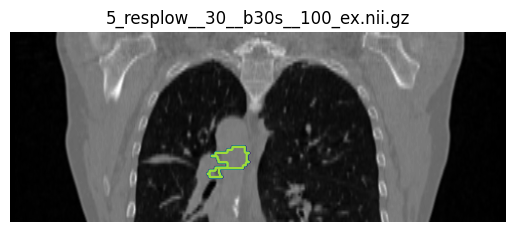

Change Size and Spacing
Change Origin
Change Size and Spacing


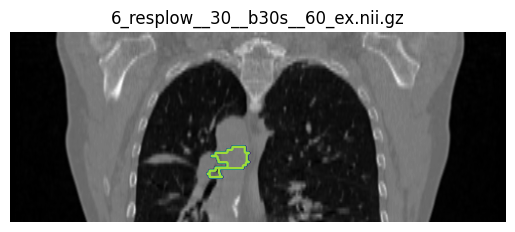

Change Size and Spacing
Change Origin
Change Size and Spacing


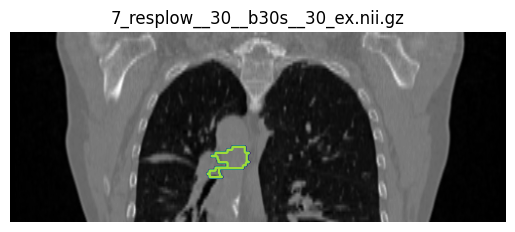

Change Size and Spacing
Change Origin
Change Size and Spacing


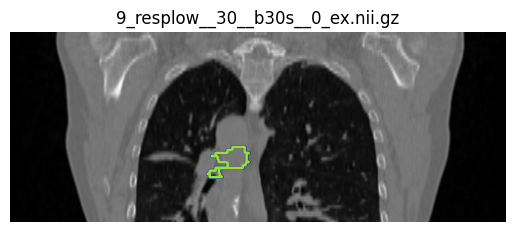

Change Size and Spacing
Change Origin
Change Size and Spacing


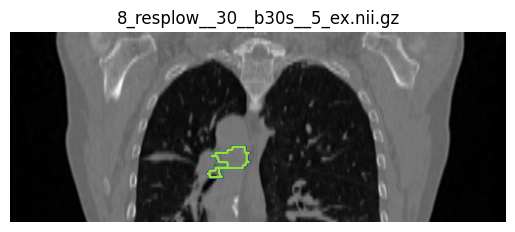

Change Size and Spacing
Change Origin
Change Size and Spacing


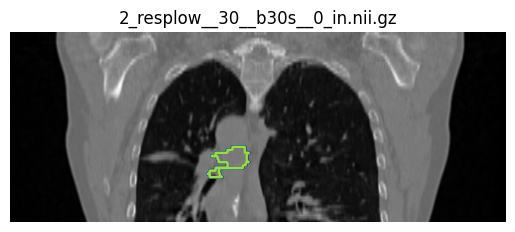

Change Size and Spacing
Change Origin
Change Size and Spacing


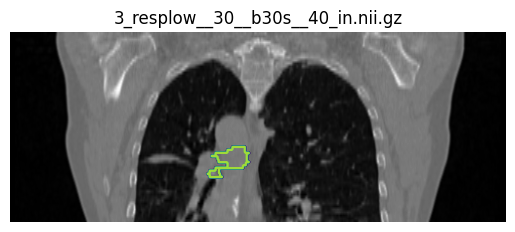

Change Size and Spacing
Change Origin
Change Size and Spacing


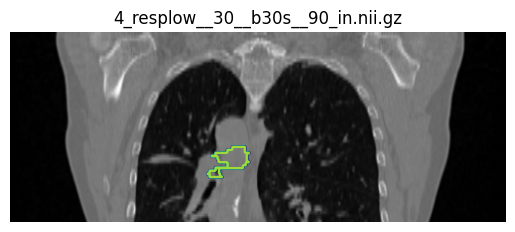

Change Size and Spacing
Change Origin
Change Size and Spacing


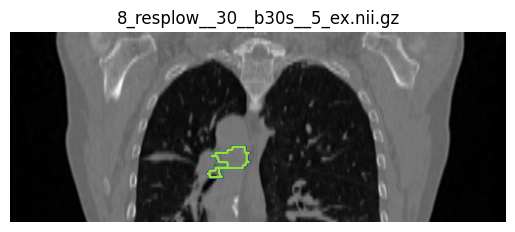

In [76]:
#BP and GTV
possibleCTs = [bp0,bp10,bp20,bp30,bp40,bp50,bp60,bp70,bp80]
for currBP in possibleCTs:
    moving_image = sitk.ReadImage(root+Px+currBP)
    normGTV = NormalizeImage(gtv_image,intFlag=None,saveFilename=None,originReference=moving_image.GetOrigin(),desired_spacing = (1,1,1),desired_Size = None)
    normBP50 = NormalizeImage(moving_image,intFlag=None,saveFilename=None,originReference=None,desired_spacing = (1,1,1),desired_Size = None)
    bp_array = sitk.GetArrayFromImage(normBP50)
    gtvOnBP_Array = sitk.GetArrayFromImage(normGTV)
    i =297
    plt.imshow(np.rot90(bp_array[:,i,:],2),cmap="gray"),plt.axis("off")
    plt.contour(np.rot90(gtvOnBP_Array[:192,i,:],2)),plt.axis("off")
    plt.title(currBP)
    plt.show()

In [ ]:
#for path2ct in possibleCTs:
#ct_np  = nib.load(root+Px+bp30)
#print(path2ct,ct_np.header["qoffset_x"],ct_np.header["qoffset_y"],ct_np.header["qoffset_z"])
Process(bp30)

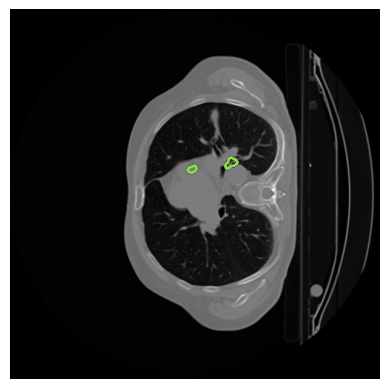

192


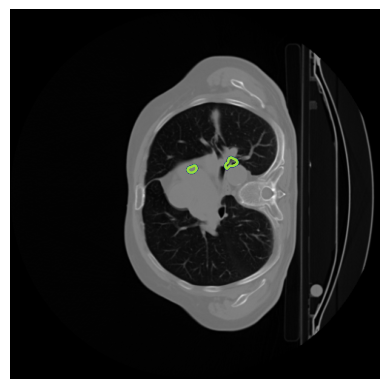

193


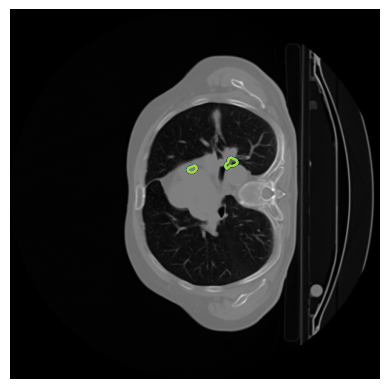

194


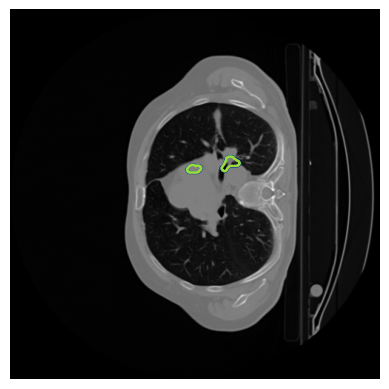

195


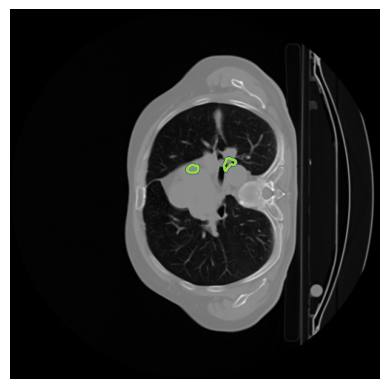

196


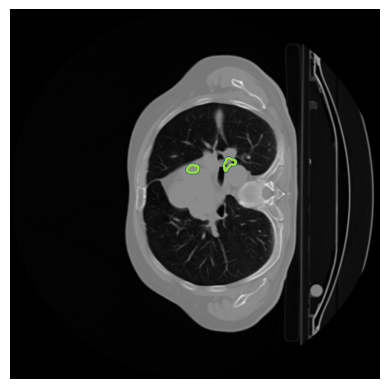

197


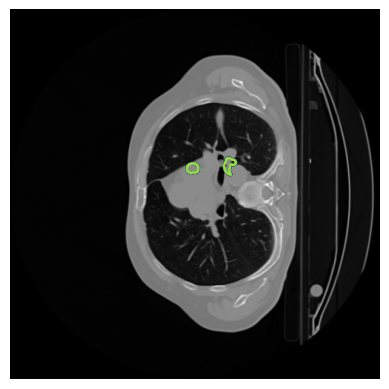

198


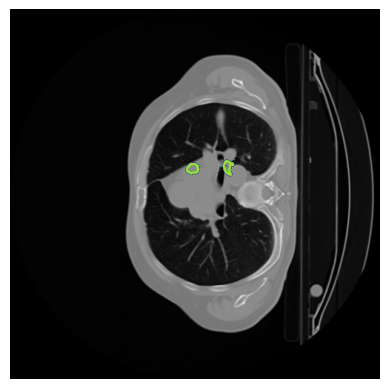

199


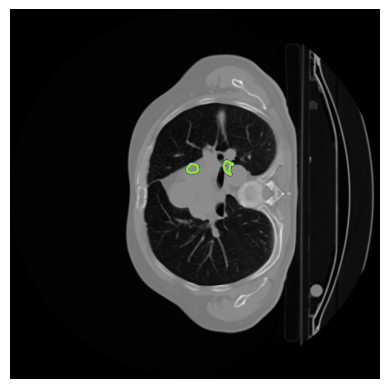

200


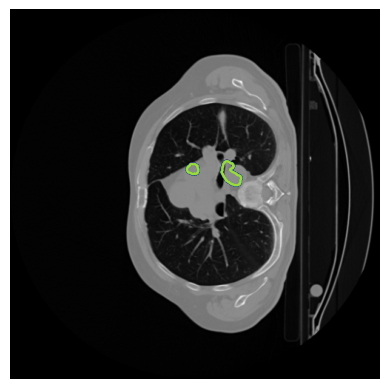

201


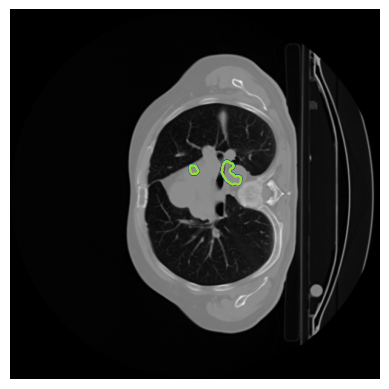

202


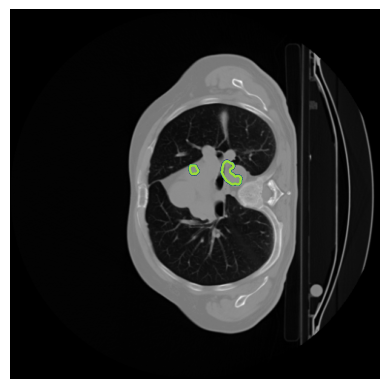

203


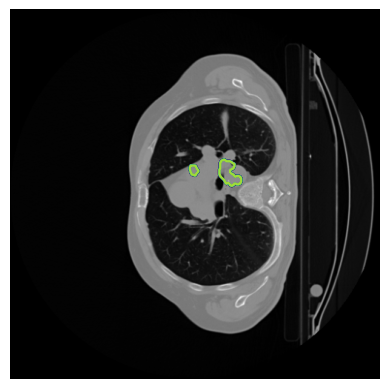

204


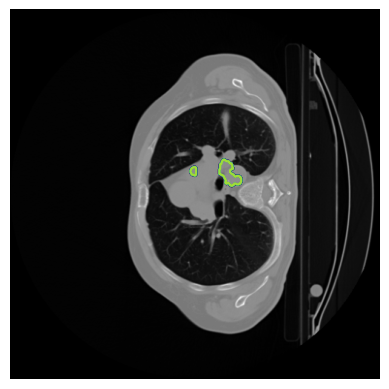

205


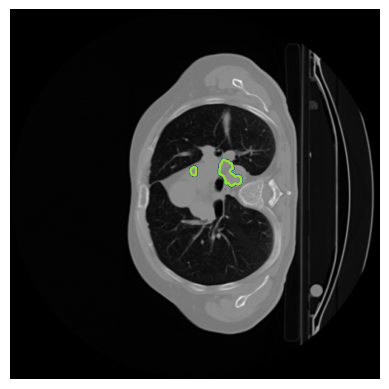

206


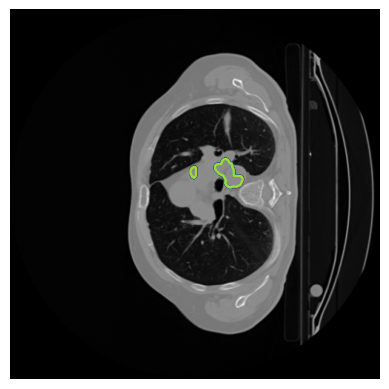

207


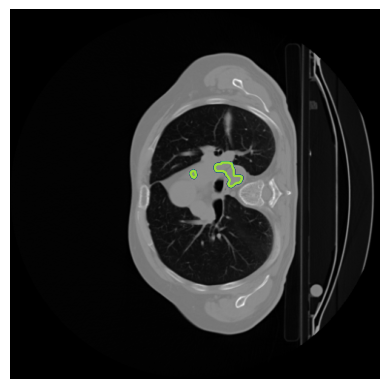

208


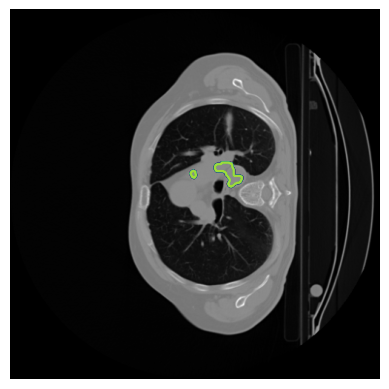

209


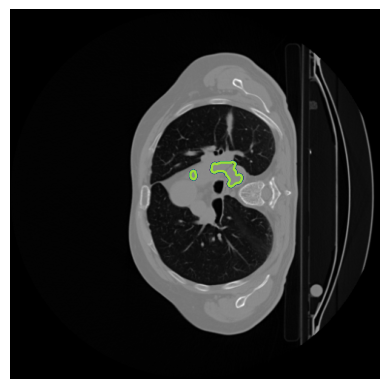

210


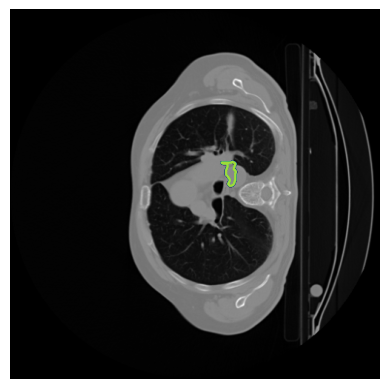

211


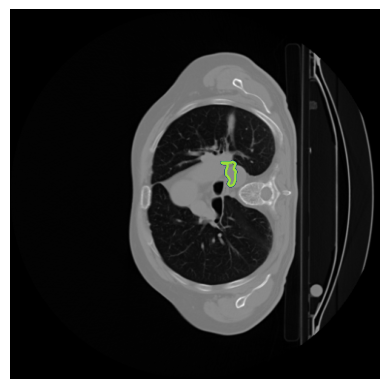

212


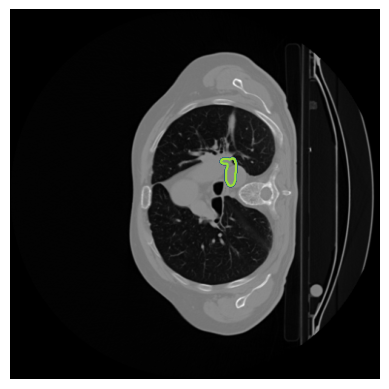

213


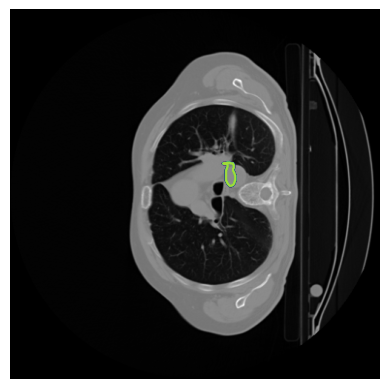

214


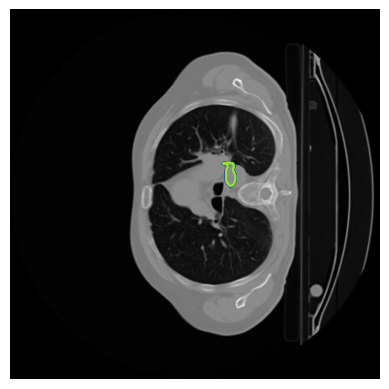

215


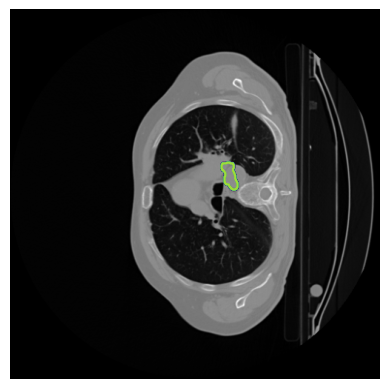

216


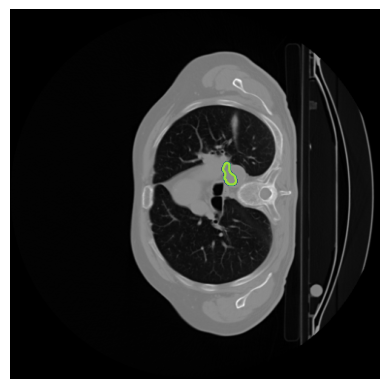

217


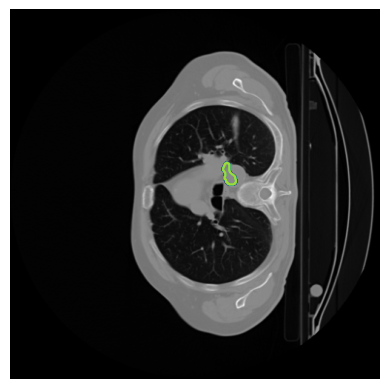

218


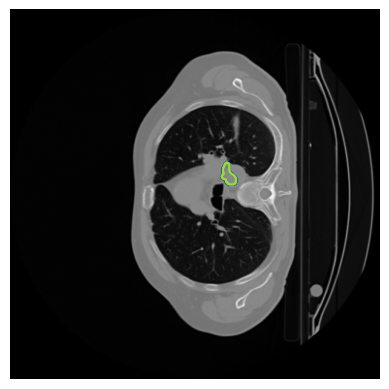

219


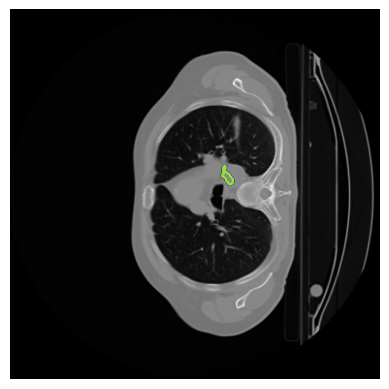

220


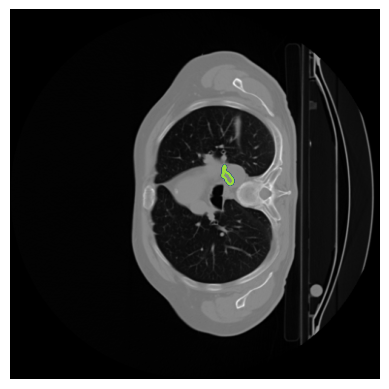

221


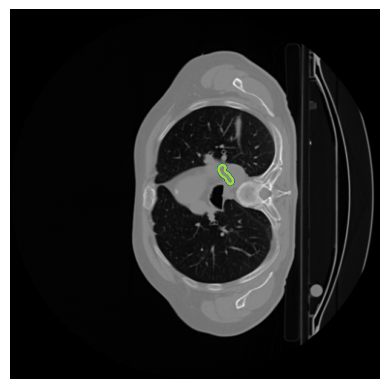

222


In [17]:
for i in range(0,ave_array.shape[-3],1):
    if np.sum(itv_array[i,:,:])>0:
        plt.imshow(np.rot90(ave_array[i,:,:]),cmap="gray"),plt.axis("off")
        plt.contour(np.rot90(itv_array[i,:,:]))
        plt.show()
        print(i)

In [ ]:
for i in range(0,itvTumorcropped.shape[-1],10):
    if np.sum(itvTumorcropped[:,:,i])>0:
        plt.imshow(np.rot90(ctcropped[:,:,i]),cmap="gray"),plt.axis("off")
        plt.contour(np.rot90(itvTumorcropped[:,:,i]))
        plt.contour(np.rot90(itvNodesCropped[:,:,i]))
        plt.show()